In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.conv_ae import *
import torch
import random
from torchvision.transforms import transforms as T
from pathlib import Path
from config import *
from load_utils import *
from conv_utils import *

import numpy as np
import platform
import json

architecture='conv_ae'

In [2]:
exp_dict = exp_name_folders(path =esa_exploration, architecture=architecture)
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_conv_ae_sl_16
num selection:1 - exp name:4_wheel_system_conv_ae_sl_40


In [7]:
select_exp = '1'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheel_system_conv_ae_sl_40


In [8]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/conv_ae/4_wheel_system_conv_ae_sl_40/summary.csv


In [9]:
summary.drop(columns = ['train_loss']).reset_index().head()

,index,Unnamed: 0,name,parameters_number,val_loss
0,28,17,"trainCONVAE_2d3ff_00029_29_activation=Elu,batc...",285321,0.005296
1,27,11,"trainCONVAE_2d3ff_00016_16_activation=Elu,batc...",189805,0.006499
2,26,1,"trainCONVAE_2d3ff_00007_7_activation=Relu,batc...",318581,0.007267
3,25,3,"trainCONVAE_2d3ff_00026_26_activation=Relu,bat...",153545,0.007280
4,24,23,"trainCONVAE_2d3ff_00023_23_activation=Elu,batc...",180185,0.010075


In [11]:
rank = 1
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'activation': 'Elu', 'batch_size': 500, 'dilation': 1, 'epochs': 200, 'filter_num': 48, 'flattened': 1, 'increasing': 0, 'kernel_size': 5, 'latent_dim': 80, 'lr': 0.0009, 'lr_patience': 10, 'n_layers': 1, 'seq_in_length': 40}


In [11]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [12]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path), map_location=device)
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [13]:
cols = cfg['dataset']['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
use_cuda = torch.cuda.is_available()
out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

columns_subset = params_conf['columns_subset']
dataset_subset = params_conf['dataset_subset']

dataset = params_conf['dataset']
train_val_split = params_conf['train_val_split']

target = params_conf['target']
batch_size = params_conf['batch_size']
sequence_length = params_conf['sequence_length']
out_window = params_conf['out_window']
predict = params_conf['predict']
activation = params_conf['activation']
kernel_size = params_conf['kernel_size']
filter_num = params_conf['filter_num']
latent_dim = params_conf['latent_dim']
n_layers = params_conf['n_layers']

increasing = params_conf['increasing']
flattened = params_conf['flattened']

In [14]:
model = CONV_AE(in_channel=1,heigth=params_conf['sequence_length'], width=len(cfg['dataset']['columns']),
                        kernel_size=params_conf['kernel_size'], filter_num=params_conf['filter_num'],
                 latent_dim=params_conf['latent_dim'], \
        n_layers=params_conf['n_layers'], activation = params_conf['activation'],
               increasing=increasing, flattened=flattened).to(device)

Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal


In [15]:
model.load_state_dict(checkpoint['model_state_dict'])
par_nums = checkpoint['parameters_number']
model.to(device).eval()
print(count_parameters(model))
model

285321


CONV_AE(
  (act): ELU(alpha=1.0)
  (encoder): Encoder(
    (nn_enc): Sequential(
      (enc_lay_0): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
      (enc_lay_1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
    )
    (act): ELU(alpha=1.0)
    (encoder_layer): Linear(in_features=1280, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (nn_dec): Sequential(
      (dec_lay_0): Sequential(
        (0): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    

In [17]:
transform = T.Compose([
                       T.ToTensor(),
                       ])


dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
df_train, df_test, train_iter, test_iter = \
read_dataset_conv(dataset_name, cfg['dataset']['scaled'],cfg['dataset']['columns_subset']
                  , cfg['dataset']['dataset_subset'], cfg['dataset']['columns'], 
                 cfg['dataset']['train_val_split'], cfg['dataset']['sequence_length']
                  , cfg['dataset']['sequence_length'],  predict=False,
                 batch_size=4, transform=transform)

In [18]:
compute_mse_val_loss = True

In [20]:
mse_val_loss_list = []
criterion = nn.MSELoss()
if compute_mse_val_loss:
    for i, (x,y) in enumerate(test_iter):
        yo = model(x)
        mse_val_loss_list.append(criterion(yo, x).item())
        print(i, np.mean(mse_val_loss_list))
    mse_val_loss = np.mean(mse_val_loss_list)
    print(mse_val_loss)
    

0 0.00490401778370142
1 0.004967362154275179
2 0.00508232166369756
3 0.005194757832214236
4 0.005234683305025101
5 0.005274064683665832
6 0.005336703732609749
7 0.0053704610909335315
8 0.005375374418993791
9 0.005406845174729824
10 0.005449062297967347
11 0.005488937837071717
12 0.00548610041061273
13 0.00548688555136323
14 0.005504100304096937
15 0.005510930990567431
16 0.00550900270943256
17 0.005514337939934598
18 0.0055168369098713525
19 0.005522986315190792
20 0.005521933570326794
21 0.005529008551754735
22 0.005532479925971964
23 0.005537131471404185
24 0.00553463289514184
25 0.005528819335338015
26 0.0055187104821757035
27 0.005496199641908918
28 0.005489026132071841
29 0.005481413938105107
30 0.0054732864241926905
31 0.005459157633595169
32 0.0054397362453693695
33 0.005427638493368731
34 0.005417977858866964
35 0.0054147275707994895
36 0.005412427935044508
37 0.005428361963774813
38 0.005415986924885939
39 0.0054044645861722525
40 0.005396313511016892
41 0.005392262734295357
4

360 0.005178266573810842
361 0.005180629231395889
362 0.005182472437353338
363 0.005184002681174776
364 0.0051846823310607104
365 0.005184367863980473
366 0.005184431583176516
367 0.0051838662209616896
368 0.005183317794446861
369 0.005182636943268212
370 0.005182668738659582
371 0.005182554838948593
372 0.005183292445464524
373 0.005183080089263578
374 0.005183426521718502
375 0.005183875666029672
376 0.005184853314829679
377 0.005186038203882398
378 0.005186869186597402
379 0.005188179362908398
380 0.00518877695625027
381 0.005189724833368085
382 0.005191837231976323
383 0.005193795402495501
384 0.005194911853011165
385 0.005195638402534041
386 0.005196024303971874
387 0.005195988577396907
388 0.005196368410359771
389 0.005197385884821415
390 0.005198935224243519
391 0.005200483643791961
392 0.005202033314095578
393 0.005203150892346568
394 0.005204507775746192
395 0.005204951544668563
396 0.005204604813120602
397 0.005203835426328994
398 0.005202278486665404
399 0.005200234347721561

KeyboardInterrupt: 

In [16]:
num_batch=10
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches_conv(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'])

time horizon 160


In [17]:
yo = model(x.to(device)).squeeze().to(device)
xs = torch.squeeze(x).to(device)
x_plot = x.squeeze().to(device)

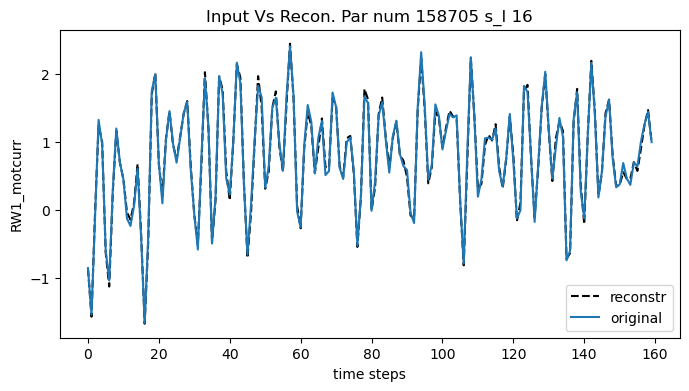

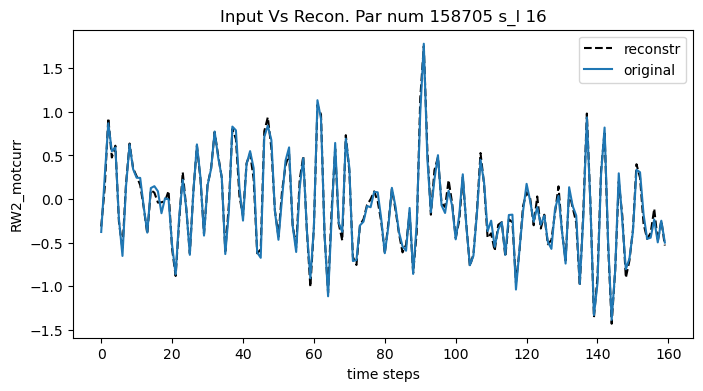

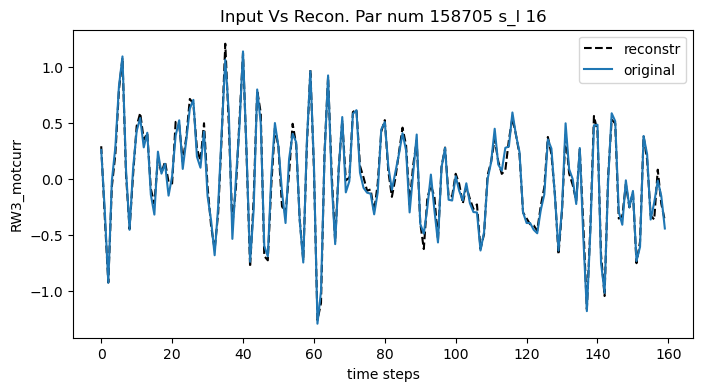

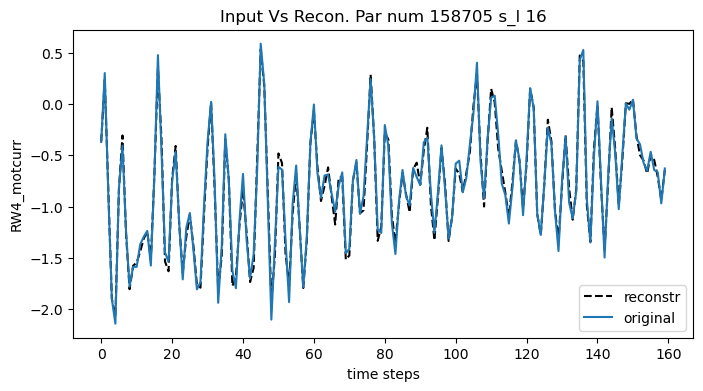

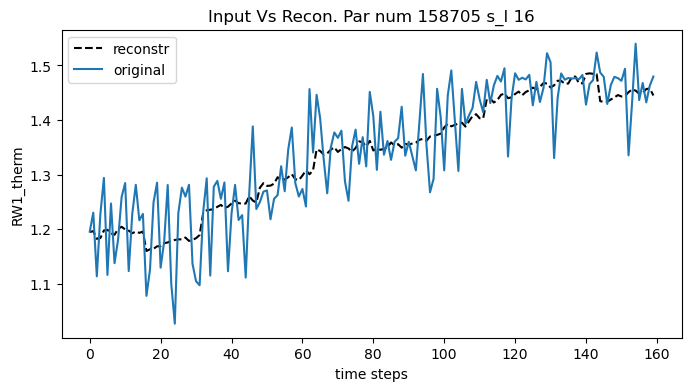

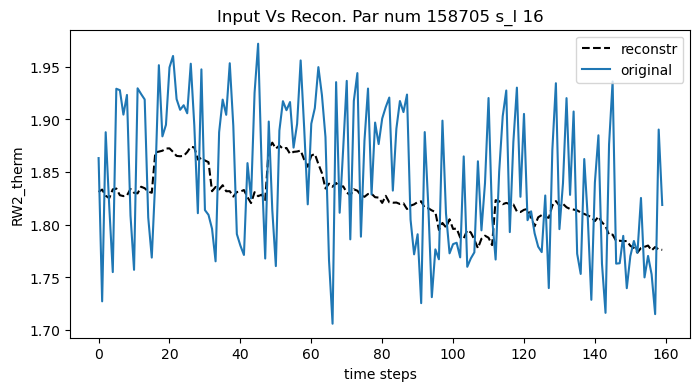

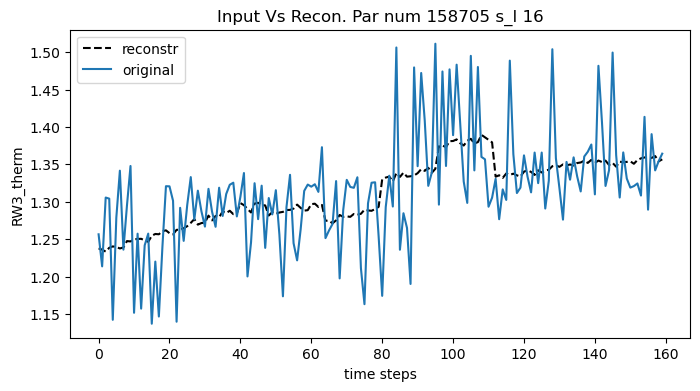

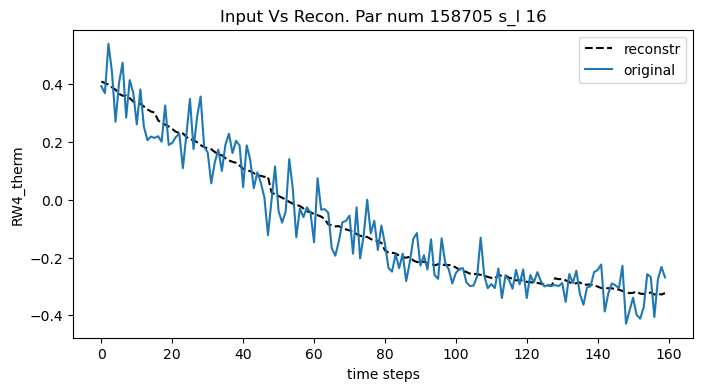

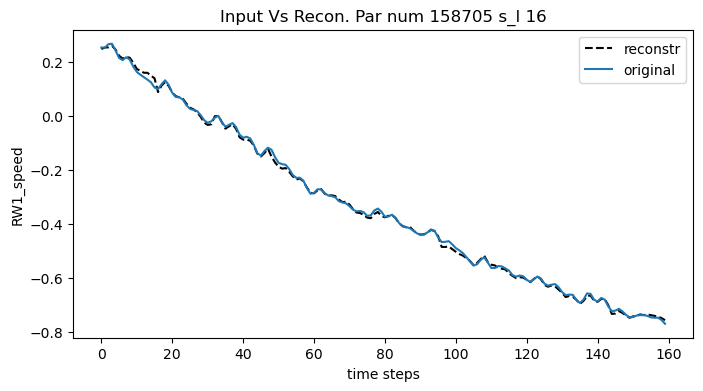

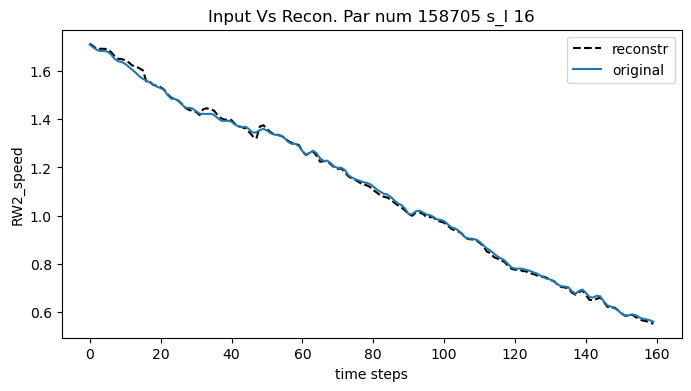

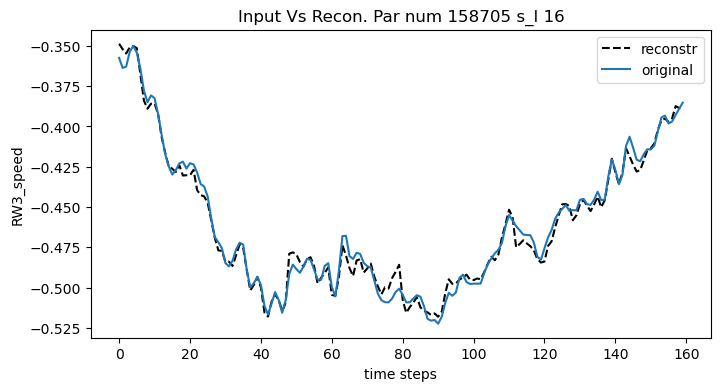

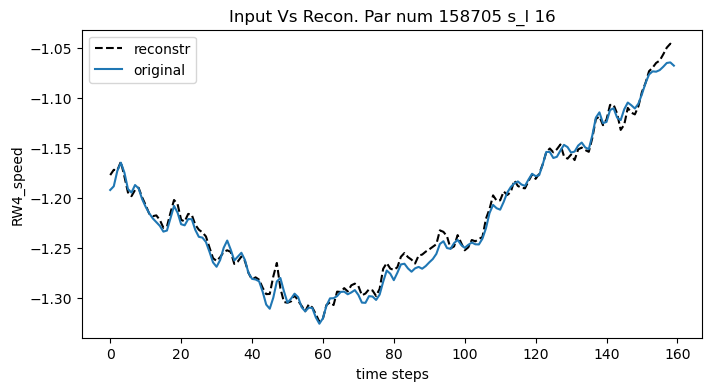

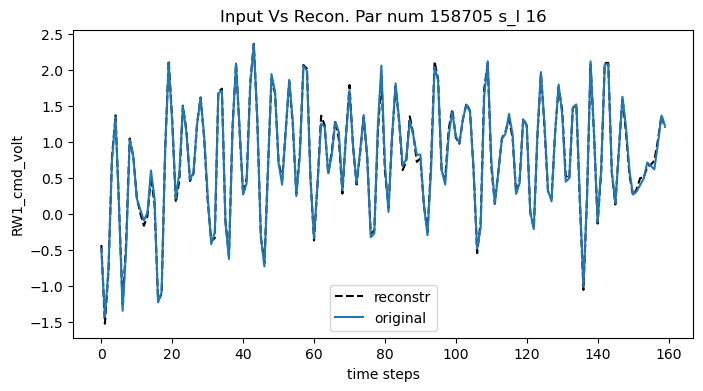

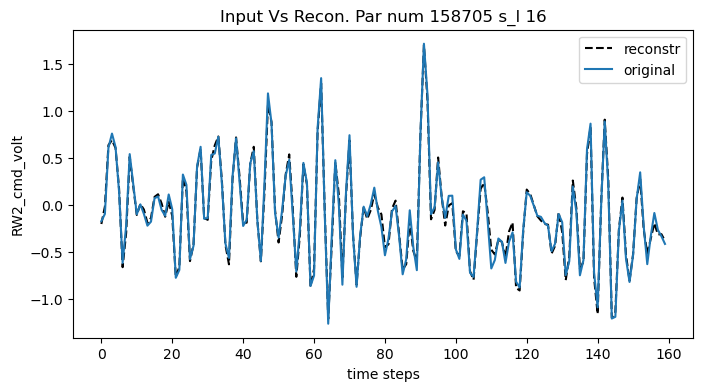

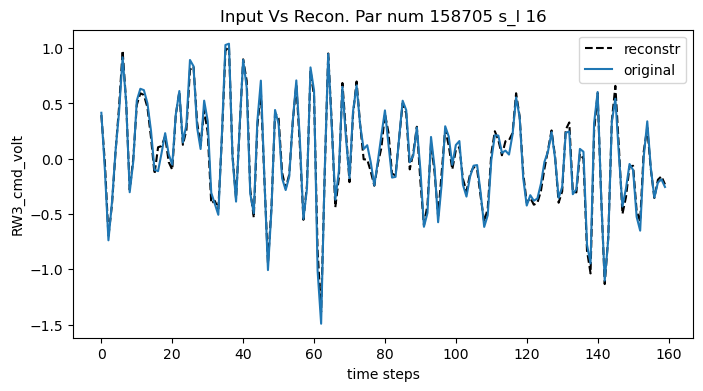

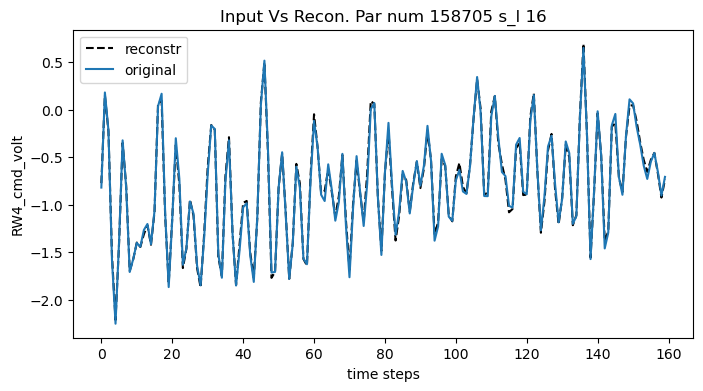

In [15]:
show_results(x_plot, yo,cols,
    model_name, params_conf,
    par_nums, shift,num_batch,
    arch=architecture,
    save=False,)